# Cyclistic Ride Analytics: Behavioral Segmentation for Membership Growth

In [1]:
import pandas as pd
import os
import glob
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [3]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Data Cleaning & Preprocessing

### a) CSV File Loading and Appending Process

In [3]:
path = r"C:\Users\ADMIN\Desktop\new"
all_files = glob.glob(os.path.join(path, '*.csv'))

In [5]:
df = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)

#### Initial Checks

In [9]:
print("Initial Data Shape:", df.shape)

Initial Data Shape: (5719877, 13)


In [11]:
print("Columns:", df.columns)

Columns: Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


In [11]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    875716
start_station_id      875848
end_station_name      929202
end_station_id        929343
start_lat                  0
start_lng                  0
end_lat                 6990
end_lng                 6990
member_casual              0
dtype: int64


In [13]:
print("Data types:\n", df.dtypes)

Data types:
 ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object


In [7]:
mapping_file = r"C:\Users\ADMIN\Desktop\station_mapping.csv"
station_map = pd.read_csv(mapping_file)

In [11]:
# Coordinate-Based Station Name Mapping
df = df.merge(
    station_map[['start_lat', 'start_lng', 'start_station_name']].drop_duplicates(),
    how='left',
    on=['start_lat', 'start_lng'],
    suffixes=('', '_mapped')
)

In [13]:
df['start_station_name'] = df['start_station_name'].fillna(df['start_station_name_mapped'])

In [15]:
df.drop(columns=['start_station_name_mapped'], inplace=True)

In [9]:
df = df.merge(
    station_map[['end_lat', 'end_lng', 'end_station_name']].drop_duplicates(),
    how='left',
    on=['end_lat', 'end_lng'],
    suffixes=('', '_mapped')
)

In [11]:
df['end_station_name'] = df['end_station_name'].fillna(df['end_station_name_mapped'])

In [13]:
df.drop(columns=['end_station_name_mapped'], inplace=True)

In [15]:
#Check
print(df['start_station_name'].isna().sum())
print(df['end_station_name'].isna().sum())

0
0


## Data Wrangling / Feature Engineering

In [7]:
# Conversion of start and end time to datetime
df['started_at'] = pd.to_datetime(df['started_at'], dayfirst=True)
df['ended_at'] = pd.to_datetime(df['ended_at'], dayfirst=True)

In [9]:
# Removal of rows with nulls in critical columns
df.dropna(subset=['started_at', 'ended_at', 'member_casual'], inplace=True)

In [11]:
# Calculation of Ride Length
df['ride_length'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

In [13]:
# Check for invalid ride lengths
print("\nRide length stats before cleaning:")
print(df['ride_length'].describe())
print("Zero or negative rides:", (df['ride_length'] <= 0).sum())


Ride length stats before cleaning:
count    5.719877e+06
mean     1.816957e+01
std      1.808434e+02
min     -1.665700e+04
25%      5.000000e+00
50%      1.000000e+01
75%      1.700000e+01
max      9.848900e+04
Name: ride_length, dtype: float64
Zero or negative rides: 88950


In [13]:
# Removal of rides with negative or zero duration
df = df[df['ride_length'] > 0].copy()

In [17]:
# Post-cleaning check
print("\nRide length stats after cleaning:")
print(df['ride_length'].describe())
print("Zero or negative rides after cleaning:", (df['ride_length'] <= 0).sum())


Ride length stats after cleaning:
count    5.630927e+06
mean     1.847248e+01
std      1.816131e+02
min      1.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.700000e+01
max      9.848900e+04
Name: ride_length, dtype: float64
Zero or negative rides after cleaning: 0


In [15]:
# Add Day of Week
df['day_of_week'] = df['started_at'].dt.day_name()

In [21]:
# Day Type
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

In [23]:
# Month
df['month'] = df['started_at'].dt.month_name()

In [25]:
# Hour of Day
df['hour'] = df['started_at'].dt.hour

In [27]:
df['hour_label'] = df['started_at'].dt.strftime('%I %p').str.lstrip('0')

In [29]:
# Hour order for plotting
hour_order = [
    '12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
    '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'
]
hour_cat = CategoricalDtype(categories=hour_order, ordered=True)
df['hour_label'] = df['hour_label'].astype(hour_cat)

## Visualizations

### a) User Overview and Ride Volume Insights

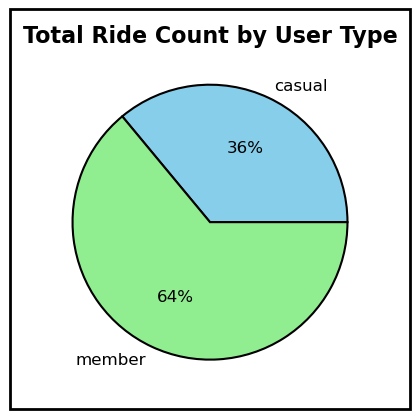

In [17]:
# 1. Total Ride Count by User Type

order = ['casual', 'member']
colors = ['skyblue', 'lightgreen']

fig, ax = plt.subplots(figsize=(4, 4))
df['member_casual'].value_counts().reindex(order).plot(
    kind='pie',
    autopct='%1.0f%%',  # Zero decimal places
    colors=colors,
    wedgeprops={'linewidth': 1.5, 'edgecolor': 'black'},
    textprops={'fontsize': 12},
    ax=ax
)
ax.set_title('Total Ride Count by User Type', fontsize=16, fontweight='bold')
ax.set_ylabel('')
ax.set_aspect('equal')

border = patches.Rectangle(
    (0, 0), 1, 1, transform=fig.transFigure,
    fill=False, edgecolor='black', linewidth=2
)
fig.patches.append(border)

plt.tight_layout()
plt.show()

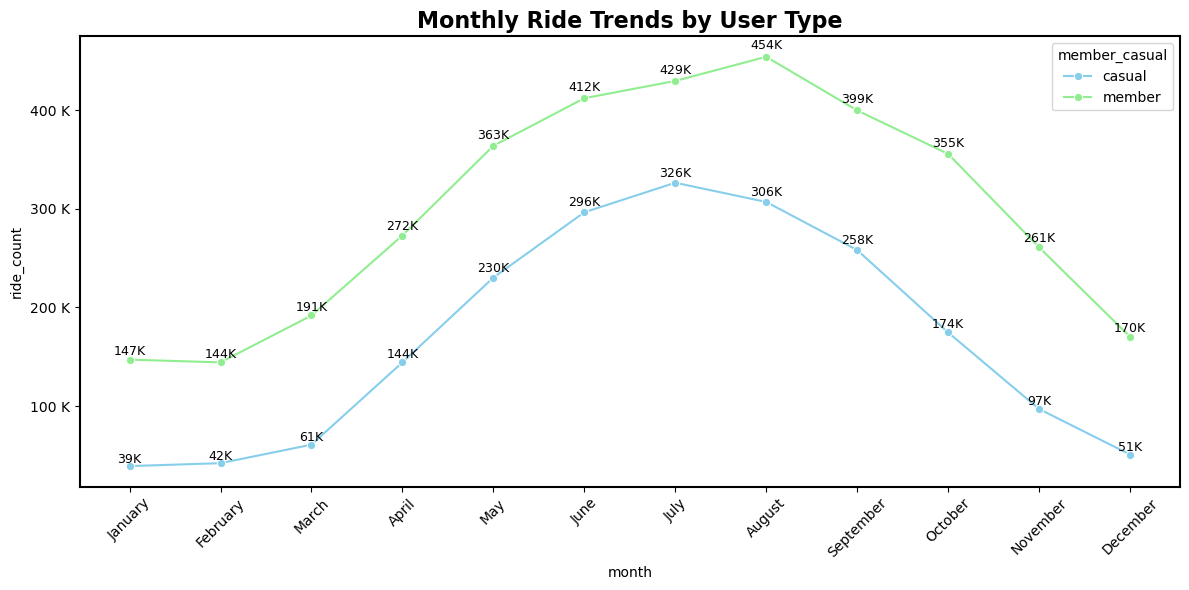

In [31]:
# 2. Monthly Ride Trends by User Type

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()

# Preparation of data
monthly = df.groupby(['month', 'member_casual']).size().reset_index(name='ride_count')
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
monthly['month'] = pd.Categorical(monthly['month'], categories=month_order, ordered=True)
monthly = monthly.sort_values('month')

# Color mapping: casual = blue, member = green
custom_palette = {'casual': 'skyblue', 'member': 'lightgreen'}

# Line chart with markers
sns.lineplot(data=monthly, x='month', y='ride_count', hue='member_casual', marker='o', ax=ax, palette=custom_palette)

# Title styling
plt.title('Monthly Ride Trends by User Type', fontsize=16, weight='bold')

# Removal of grid
ax.grid(False)

# Rotation of x-axis labels
plt.xticks(rotation=45)

# Addition of border around entire plot area
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# Formatting Y-axis in 'K'
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)} K'))

# Marker labels in 'K' format (top-center)
for _, row in monthly.iterrows():
    label = f"{int(row['ride_count'] / 1000)}K"
    ax.text(
        x=row['month'],
        y=row['ride_count'] + (row['ride_count'] * 0.01),  # slightly above marker
        s=label,
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

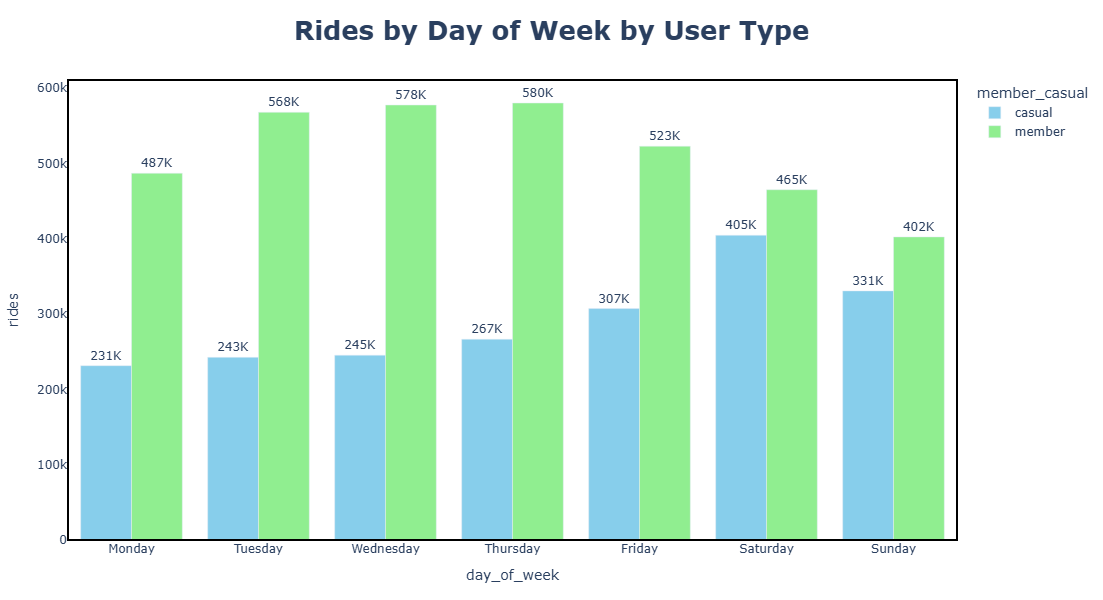

In [53]:
# 3. Rides by Day of Week by User Type

# Sample grouping & ordering
day_trend = df.groupby(['day_of_week', 'member_casual']).size().reset_index(name='rides')
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_trend['day_of_week'] = pd.Categorical(day_trend['day_of_week'], categories=day_order, ordered=True)

# Formatting rides for labels (K)
day_trend['rides_k'] = (day_trend['rides'] / 1000).round(0).astype(int).astype(str) + 'K'

# Custom color mapping
color_map = {'casual': 'skyblue', 'member': 'lightgreen'}

# Bar chart with custom colors
fig3 = px.bar(
    day_trend.sort_values('day_of_week'),
    x='day_of_week',
    y='rides',
    color='member_casual',
    color_discrete_map=color_map,
    barmode='group',
    title='Rides by Day of Week by User Type',
    text='rides_k'
)

# Bar labels
fig3.update_traces(
    textposition='outside',
    textfont=dict(size=12),  # normal font
    insidetextanchor='middle'
)

# Formatting 
fig3.update_yaxes(
    tickformat=',~s',
    showgrid=False
)

fig3.update_xaxes(showgrid=False)
fig3.update_layout(
    title=dict(
        text='<b>Rides by Day of Week by User Type</b>',
        font=dict(size=26),
        x=0.5
    ),
    width=1000,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=60, r=60, t=80, b=60),  # extra top margin for title + border
    shapes=[
        dict(
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1,
            y1=1,
            line=dict(color="black", width=2),
            layer="above"
        )
    ]
)

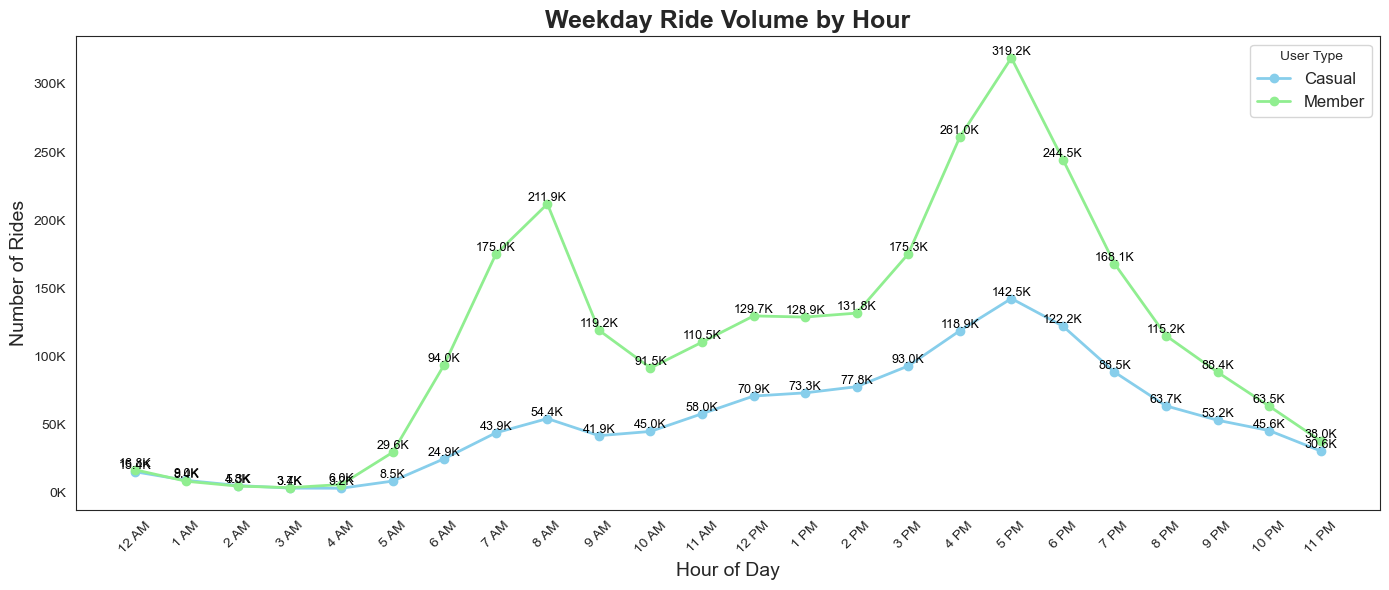

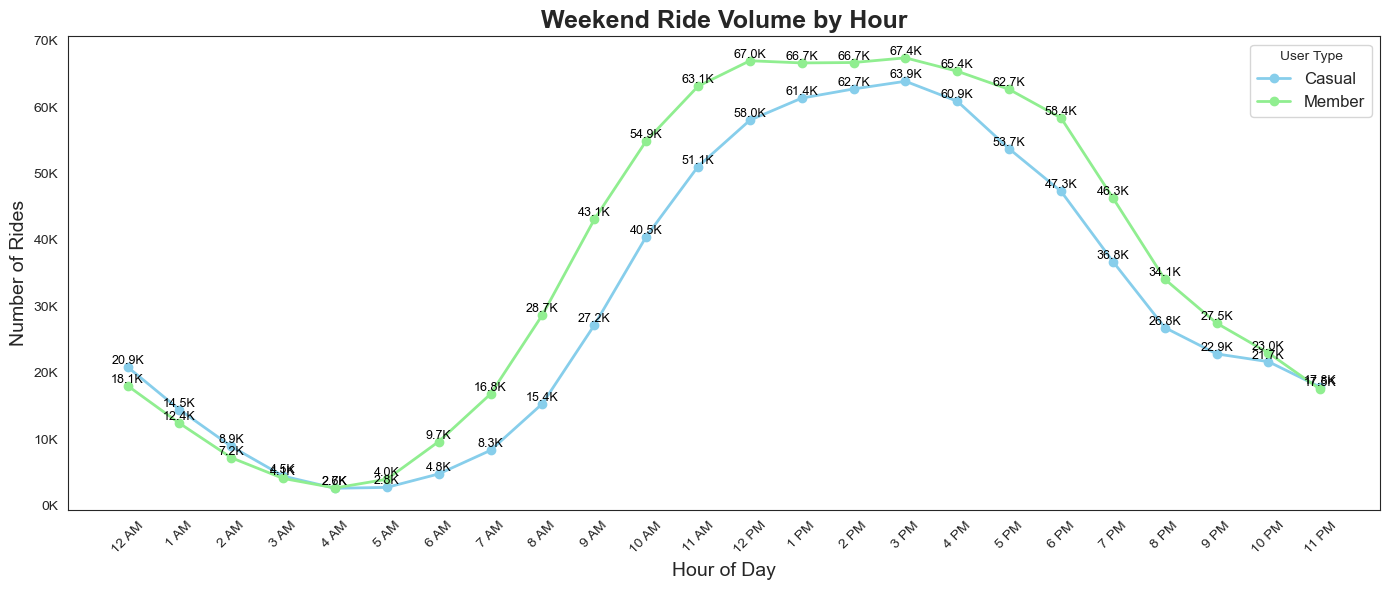

In [33]:
# 4. Rides by Hour of Day - Weekday vs. Weekend

# Filter data for weekday and weekend
weekday_df = df[df['day_type'] == 'Weekday']
weekend_df = df[df['day_type'] == 'Weekend']

# Group by hour_label and member_casual to get ride counts
weekday_counts = weekday_df.groupby(['hour_label', 'member_casual'], observed=True).size().reset_index(name='ride_count')
weekend_counts = weekend_df.groupby(['hour_label', 'member_casual'], observed=True).size().reset_index(name='ride_count')

# Colors for user types
colors = {'casual': 'skyblue', 'member': 'lightgreen'}

# Formatter to show y-axis in 'k'
def thousands_formatter(x, pos):
    return f'{int(x/1000)}K'

def plot_ride_volume(data, day_type):
    plt.figure(figsize=(14, 6))
    sns.set_style('white')  # Remove grid

    # Plot lines with markers
    for user_type in data['member_casual'].unique():
        subset = data[data['member_casual'] == user_type]
        plt.plot(
            subset['hour_label'], 
            subset['ride_count'],  
            label=user_type.capitalize(), 
            color=colors[user_type],
            marker='o',
            linewidth=2
        )
        # Marker labels on top, centered
        for x, y in zip(subset['hour_label'], subset['ride_count']):
            plt.text(
                x, y, f"{y/1000:.1f}K", 
                ha='center', va='bottom', fontsize=9, color='black'
            )

    # Title and labels
    plt.title(f'{day_type} Ride Volume by Hour', fontsize=18, fontweight='bold')
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Number of Rides', fontsize=14)
    plt.xticks(rotation=45)

    # Formatting y-axis ticks to 'k'
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

    # legend 
    plt.legend(title='User Type', fontsize=12, loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot weekday and weekend charts
plot_ride_volume(weekday_counts, 'Weekday')
plot_ride_volume(weekend_counts, 'Weekend')


### c) Ride Behavior and Duration Patterns

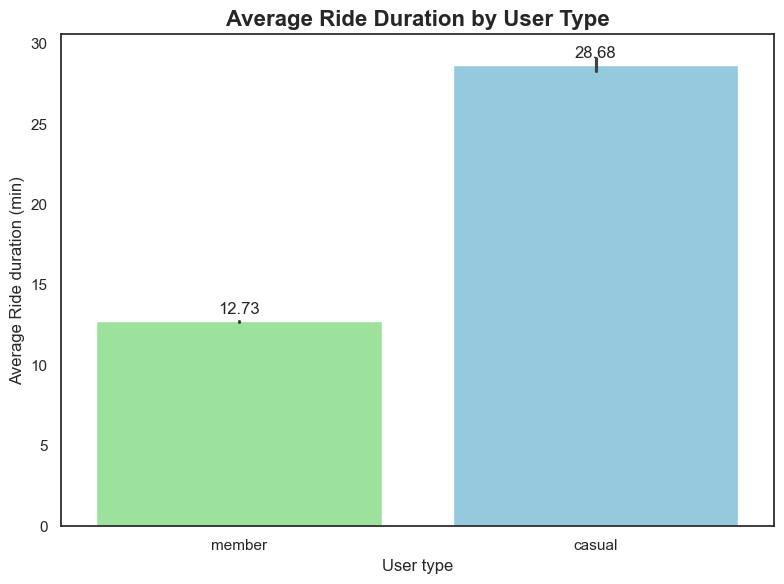

In [59]:
# 1. Average Ride Duration by User Type

# Color mapping
color_map = {'casual': 'skyblue', 'member': 'lightgreen'}

# Figure size
plt.figure(figsize=(8, 6))

# Plot with hue to apply custom colors properly
ax = sns.barplot(
    data=df,
    x='member_casual',
    y='ride_length',
    estimator='mean',
    hue='member_casual',
    palette=color_map,
    legend=False  
)

# Value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

# Axis labels title
plt.title('Average Ride Duration by User Type', fontsize=16, fontweight='bold')
plt.xlabel('User type')
plt.ylabel('Average Ride duration (min)')

plt.tight_layout()
plt.show()

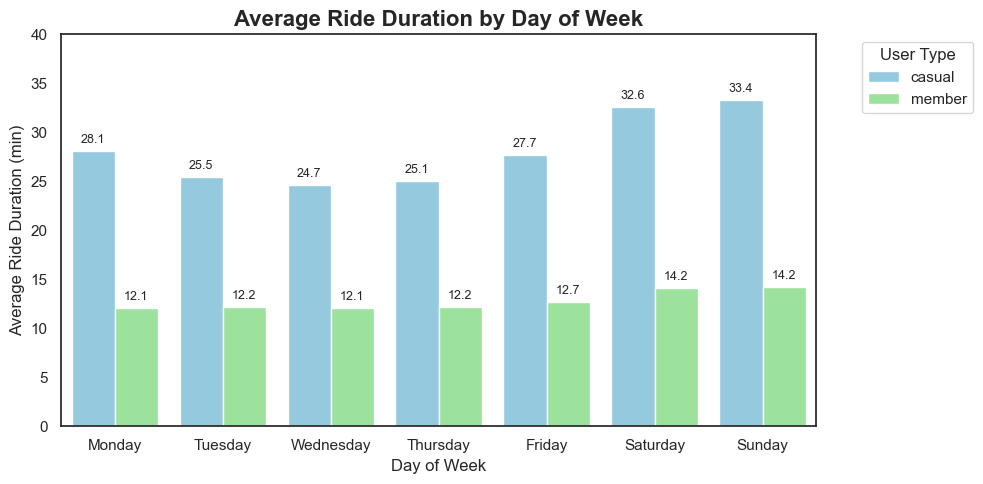

In [63]:
# 2. Average ride duration by day of week
from itertools import product

# Ensure correct day order
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
members = ['casual', 'member']

# Average ride duration
avg_ride_duration = df.groupby(['day_of_week', 'member_casual'])['ride_length'].mean().reset_index()

all_combinations = pd.DataFrame(product(days, members), columns=['day_of_week', 'member_casual'])
avg_ride_duration = all_combinations.merge(avg_ride_duration, on=['day_of_week', 'member_casual'], how='left')

# Plot Settings
plt.figure(figsize=(10, 5))
sns.set_style("white")

ax = sns.barplot(
    data=avg_ride_duration,
    x='day_of_week',
    y='ride_length',
    hue='member_casual',
    order=days,
    palette={'casual': 'skyblue', 'member': 'lightgreen'}
)

# Title and axis labels
plt.title('Average Ride Duration by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Ride Duration (min)', fontsize=12)

# Removal of gridlines
ax.grid(False)

# labels to bars 
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.5,
            f'{height:.1f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.ylim(0, avg_ride_duration['ride_length'].max() * 1.2)
plt.tight_layout()
plt.show()

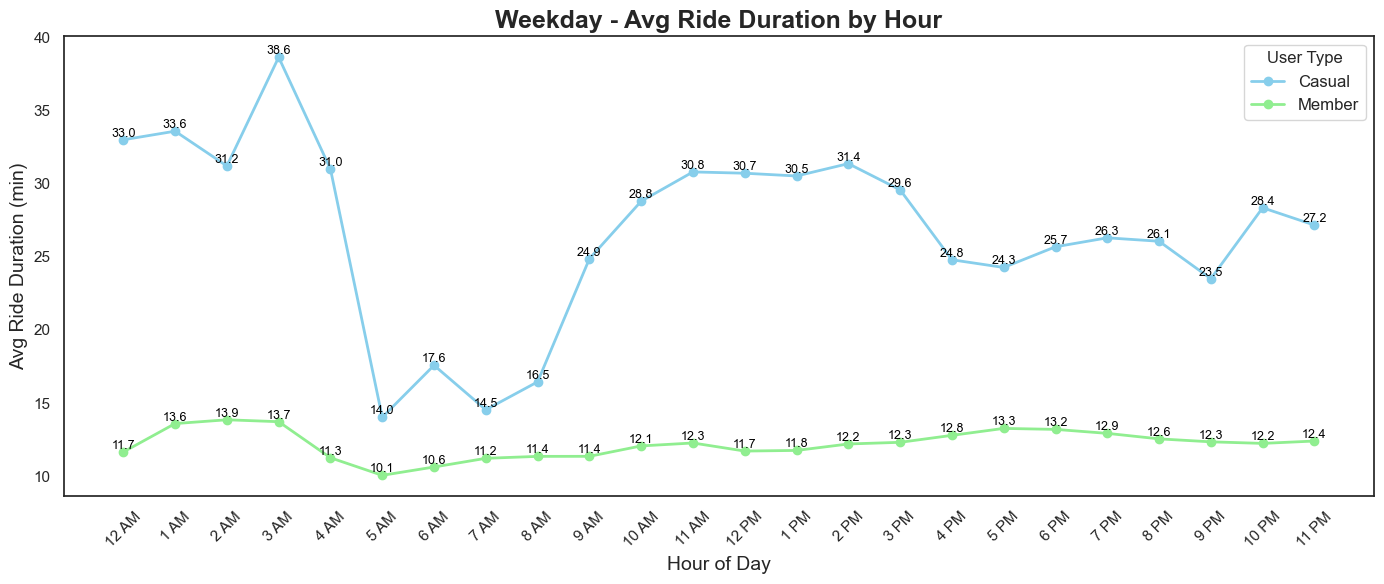

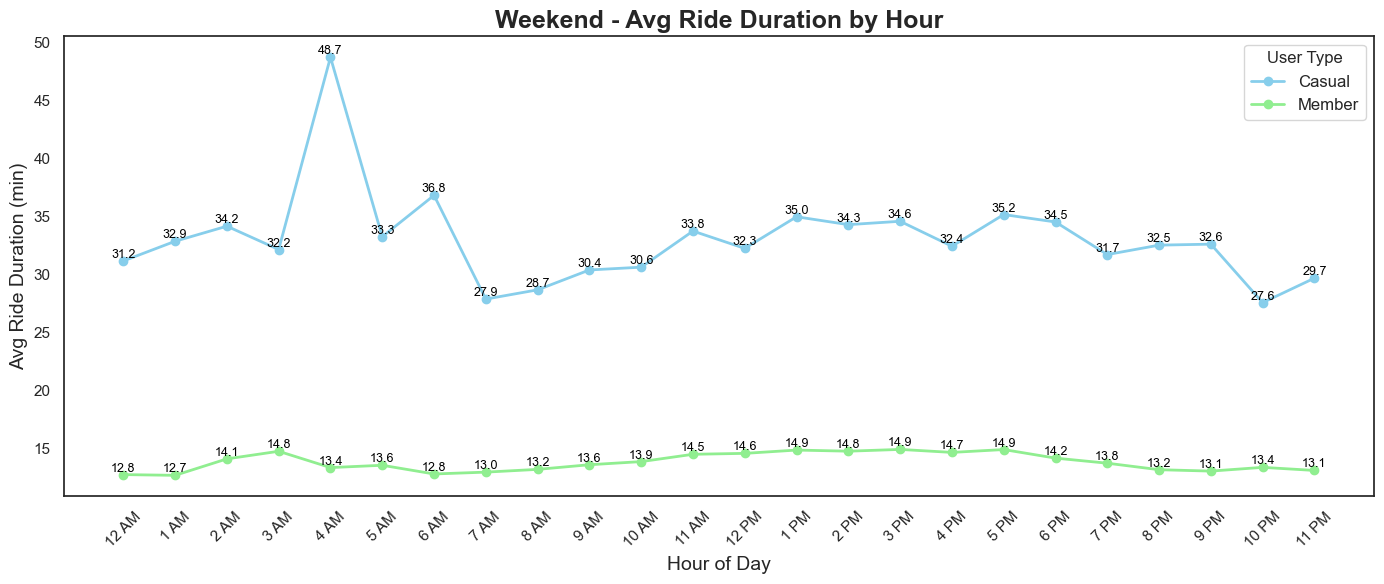

In [69]:
# 3. Average Ride Duration by Hour – Weekday vs. Weekend

# Filter data for weekday and weekend
weekday_df = df[df['day_type'] == 'Weekday']
weekend_df = df[df['day_type'] == 'Weekend']

# Group by hour_label and member_casual to get average ride duration
weekday_avg_duration = (
    weekday_df.groupby(['hour_label', 'member_casual'], observed=True)['ride_length']
    .mean()
    .reset_index(name='avg_ride_duration')
)

weekend_avg_duration = (
    weekend_df.groupby(['hour_label', 'member_casual'], observed=True)['ride_length']
    .mean()
    .reset_index(name='avg_ride_duration')
)

# colors for user types
colors = {'casual': 'skyblue', 'member': 'lightgreen'}

def plot_avg_ride_duration(data, day_type):
    plt.figure(figsize=(14, 6))
    sns.set_style('white')  # Clean look without grid

    # Plot lines with markers
    for user_type in data['member_casual'].unique():
        subset = data[data['member_casual'] == user_type]
        plt.plot(
            subset['hour_label'], 
            subset['avg_ride_duration'],  
            label=user_type.capitalize(), 
            color=colors[user_type],
            marker='o',
            linewidth=2
        )
        # Add marker labels
        for x, y in zip(subset['hour_label'], subset['avg_ride_duration']):
            plt.text(
                x, y, f"{y:.1f}", 
                ha='center', va='bottom', fontsize=9, color='black'
            )

    # Title and labels
    plt.title(f'{day_type} - Avg Ride Duration by Hour', fontsize=18, fontweight='bold')
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Avg Ride Duration (min)', fontsize=14)
    plt.xticks(rotation=45)

    plt.legend(title='User Type', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot charts
plot_avg_ride_duration(weekday_avg_duration, 'Weekday')
plot_avg_ride_duration(weekend_avg_duration, 'Weekend')

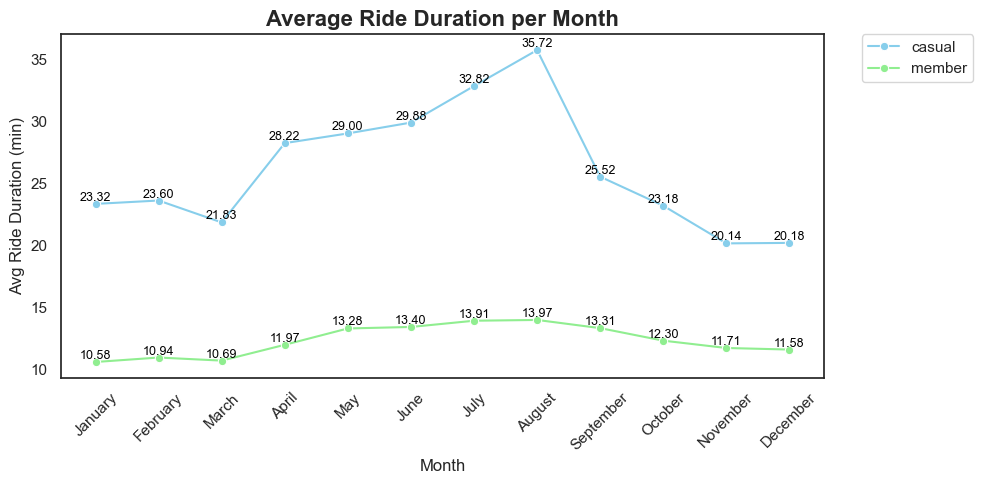

In [71]:
# 4. Average ride duration per month

monthly_avg = df.groupby(['month', 'member_casual'])['ride_length'].mean().reset_index()

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

monthly_avg['month'] = pd.Categorical(monthly_avg['month'], categories=month_order, ordered=True)
monthly_avg = monthly_avg.sort_values('month')

plt.figure(figsize=(10, 5))

custom_palette = {'casual': 'skyblue', 'member': 'lightgreen'}

ax = sns.lineplot(
    data=monthly_avg,
    x='month',
    y='ride_length',
    hue='member_casual',
    marker='o',
    palette=custom_palette
)

ax.grid(False)

for line in ax.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for (x, y) in zip(x_data, y_data):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.title('Average Ride Duration per Month', fontsize=16, fontweight='bold')
plt.ylabel('Avg Ride Duration (min)')
plt.xlabel('Month')
plt.xticks(rotation=45)

# Legend 
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.tight_layout()
plt.show()

### c) Spatial Usage Patterns

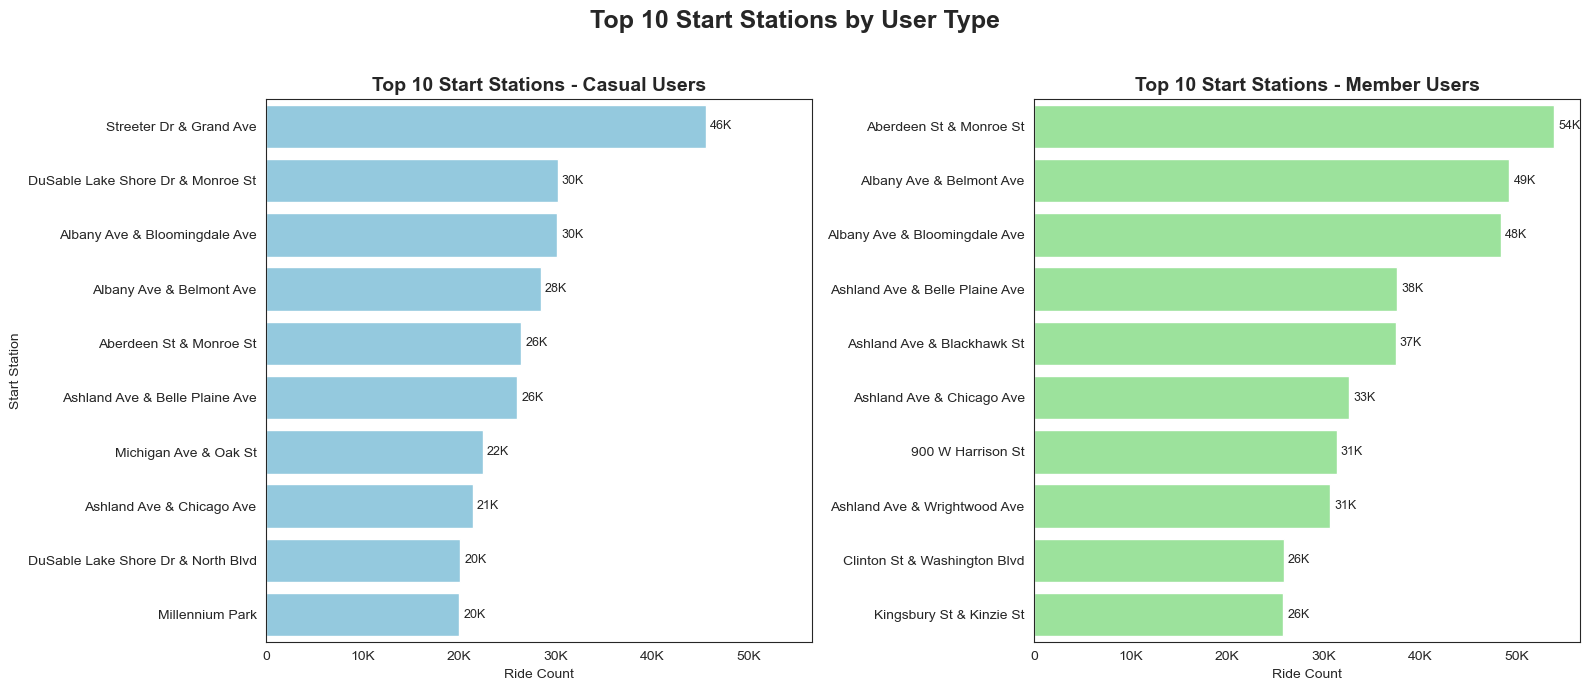

In [37]:
# 1. Top 10 Start Stations by User type
from matplotlib.ticker import FuncFormatter

# Preparation of data
top_starts = df.groupby(['start_station_name', 'member_casual']).size().reset_index(name='count')
top_starts = top_starts.sort_values('count', ascending=False).groupby('member_casual').head(10)

# Split data by user type
casual_data = top_starts[top_starts['member_casual'] == 'casual']
member_data = top_starts[top_starts['member_casual'] == 'member']

# Formatter function to convert to 'K' format
def thousands_formatter(x, pos):
    return f'{x*1.0/1000:.0f}K' if x >= 1000 else f'{int(x)}'

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True)

# Plot for casual users
casual_plot = sns.barplot(
    data=casual_data,
    ax=axes[0],
    y='start_station_name',
    x='count',
    color='skyblue'
)
axes[0].set_title('Top 10 Start Stations - Casual Users', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Ride Count')
axes[0].set_ylabel('Start Station')
axes[0].grid(False)

# x-axis and bar labels
axes[0].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
for container in casual_plot.containers:
    casual_plot.bar_label(
        container,
        labels=[f'{v/1000:.0f}K' if v >= 1000 else str(int(v)) for v in container.datavalues],
        label_type='edge',
        fontsize=9,
        padding=3
    )

# Plot for member users
member_plot = sns.barplot(
    data=member_data,
    ax=axes[1],
    y='start_station_name',
    x='count',
    color='lightgreen'
)
axes[1].set_title('Top 10 Start Stations - Member Users', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Ride Count')
axes[1].set_ylabel('')
axes[1].grid(False)

# x-axis and bar labels
axes[1].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
for container in member_plot.containers:
    member_plot.bar_label(
        container,
        labels=[f'{v/1000:.0f}K' if v >= 1000 else str(int(v)) for v in container.datavalues],
        label_type='edge',
        fontsize=9,
        padding=3
    )

# Overall title
fig.suptitle('Top 10 Start Stations by User Type', fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

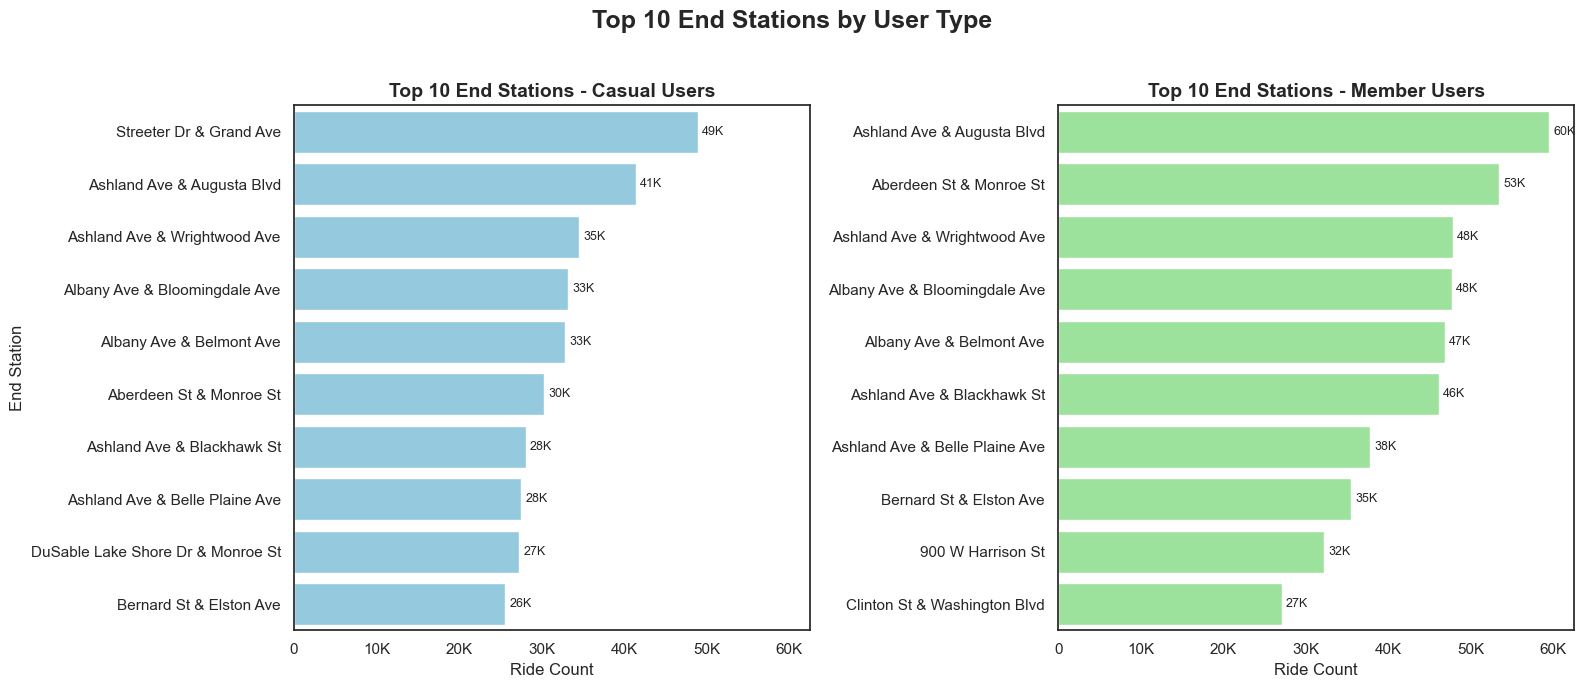

In [75]:
# 2. Top 10 End Stations

# Prepare end station data
top_ends = df.groupby(['end_station_name', 'member_casual']).size().reset_index(name='count')
top_ends = top_ends.sort_values('count', ascending=False).groupby('member_casual').head(10)

# Split data by user type
casual_end = top_ends[top_ends['member_casual'] == 'casual']
member_end = top_ends[top_ends['member_casual'] == 'member']

# Formatter for "K" notation
def thousands_formatter(x, pos):
    return f'{x*1.0/1000:.0f}K' if x >= 1000 else f'{int(x)}'

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True)

# Plot for casual users
casual_plot = sns.barplot(
    data=casual_end,
    ax=axes[0],
    y='end_station_name',
    x='count',
    color='skyblue'
)
axes[0].set_title('Top 10 End Stations - Casual Users', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Ride Count')
axes[0].set_ylabel('End Station')
axes[0].grid(False)

# Format x-axis and bar labels
axes[0].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
for container in casual_plot.containers:
    casual_plot.bar_label(
        container,
        labels=[f'{v/1000:.0f}K' if v >= 1000 else str(int(v)) for v in container.datavalues],
        label_type='edge',
        fontsize=9,
        padding=3
    )

# Plot for member users
member_plot = sns.barplot(
    data=member_end,
    ax=axes[1],
    y='end_station_name',
    x='count',
    color='lightgreen'
)
axes[1].set_title('Top 10 End Stations - Member Users', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Ride Count')
axes[1].set_ylabel('')
axes[1].grid(False)

# x-axis and bar labels
axes[1].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
for container in member_plot.containers:
    member_plot.bar_label(
        container,
        labels=[f'{v/1000:.0f}K' if v >= 1000 else str(int(v)) for v in container.datavalues],
        label_type='edge',
        fontsize=9,
        padding=3
    )

# Overall title
fig.suptitle('Top 10 End Stations by User Type', fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### d) Bike Type Preferences

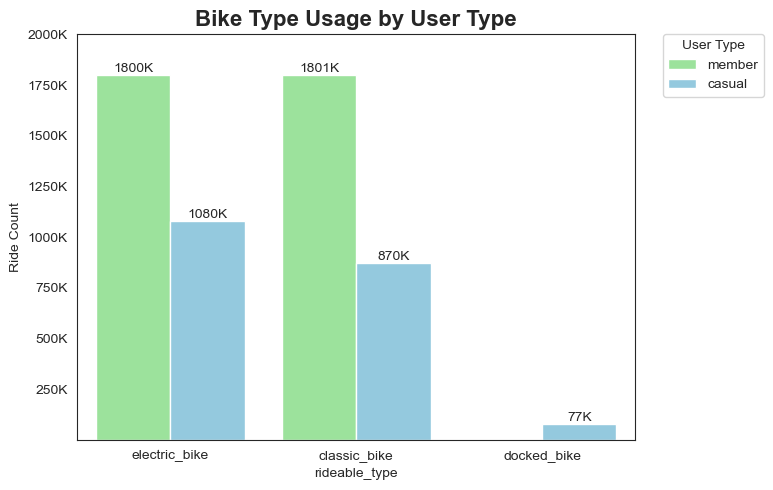

In [43]:
# Bike Type Usage by User Type

# Color formatting
colors = {'member': 'lightgreen', 'casual': 'skyblue'}

# Figure settings
plt.figure(figsize=(8, 5))  # Increased size for better layout
ax = sns.countplot(data=df, x='rideable_type', hue='member_casual', palette=colors)

# Title formatting
plt.title('Bike Type Usage by User Type', fontsize=16, fontweight='bold')

# Format y-axis in 'k' and remove 0k
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
yticks = [tick for tick in ax.get_yticks() if tick != 0]
ax.set_yticks(yticks)

# Y-axis label
ax.set_ylabel('Ride Count')

# Bar labels in thousands
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid labeling zero-height bars
        ax.annotate(f'{int(height/1000)}K',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

# Legend
plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()